### This notebook contains the codes to extract and process the necessary simulation data for constructing the machine learning model. The contents must be incorporated to the resilience_metrics.py once finalized.

In [5]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

from IPython.display import clear_output

import os
import pandas as pd
from pathlib import Path
from sklearn import metrics
import statistics
import numpy as np
import copy

import infrarisk.src.network_sim_models.interdependencies as interdependencies
from infrarisk.src.network_sim_models.integrated_network import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
network_dir = Path('../../data/networks/micropolis')
water_folder = network_dir/'water'
power_folder = network_dir/'power'

micropolis_network = IntegratedNetwork(name = 'Micropolis', 
                                       water_folder= water_folder,
                                       power_folder = power_folder,
                                       water_sim_type = 'PDA',
                                       power_sim_type='1ph')

Water network successfully loaded from ..\..\data\networks\micropolis\water/water.inp. The analysis type is set to PDA.
initial simulation duration: 60s; hydraulic time step: 60s; pattern time step: 3600s

Power system successfully loaded from ..\..\data\networks\micropolis\power\power.json. Single phase power flow simulation will be used.



In [3]:
link_criticality_measures = pd.read_csv(f"{network_dir}/link_criticality_features.csv", sep = ",")
link_criticality_measures.head()

,source,target,id,link_type,betweenness_centrality,cluster_num,katz_centrality,maxflow,length,link_category,degree_centrality,eigenvector_centrality,closeness_centrality,cluster
0,P_B0,P_B1,P_L1,Power,0.082426,7,-0.027746,18.058576,100.363,Power line,0.005719,3.399758e-17,0.000737,power7
1,P_B0,P_B79,P_L394,Power,0.057579,2,-0.043812,0.662464,56.033,Power line,0.005719,1.081720e-17,0.000724,power2
2,P_B1,P_B2,P_L2,Power,0.064377,7,0.013581,17.638314,183.230,Power line,0.004902,3.457825e-17,0.000756,power7
3,P_B2,P_B3,P_L3,Power,0.080543,7,0.001400,16.372524,199.139,Power line,0.004902,4.053703e-18,0.000780,power7
4,P_B3,P_B4,P_L4,Power,0.091090,7,-0.029408,15.137651,165.686,Power line,0.004902,-1.699627e-17,0.000802,power7


In [6]:
# Set scenarios folder
folder = Path('../../data/networks/micropolis/scenarios')
scenarios = [f for f in sorted(os.listdir(folder))]

#list of recovery strategies to be considered
#strategies = ['capacity', 'centrality', 'crewdist', 'zone']
strategies = ['capacity', 'zone', 'centrality']

#create the empty dataframe for ML dataset

columns = ["scenario", "strategy", 'water_perf_ecs', 'water_perf_pcs', 'power_perf_ecs',
         'power_perf_pcs', "all_compons"] + list(link_criticality_measures.cluster.unique())
         
ml_df = pd.DataFrame(columns = columns)

abnormal_results = []

junc_list = micropolis_network.wn.junction_name_list
base_water_demands = micropolis_network.base_water_node_supply
base_power_demands = micropolis_network.base_power_supply


In [8]:
for index, scenario in enumerate(scenarios):
    print(index,"/",len(scenarios), ". ", scenario)
    # ml_df_new = {"scenario": scenario,
    #      "strategy": None,
    #      'water_perf_ecs': None,
    #      'water_perf_pcs': None,
    #      'power_perf_ecs': None ,
    #      'power_perf_pcs': None,
    #      "water_mains": 0, "water_pumps": 0, "water_tanks":0,
    #      "power_lines": 0, "transpo_links": 0, "all_compons": 0}
    ml_df_new = dict()
    for key in columns:
        if key == 'scenario':
            ml_df_new[key] = scenario
        elif key in ["strategy", 'water_perf_ecs', 'water_perf_pcs', 'power_perf_ecs', 'power_perf_pcs']:
            ml_df_new[key] = None
        else:
            ml_df_new[key] = 0
    
    disruption_file = pd.read_csv(f"{folder}/{scenario}/disruption_file.csv")
    ml_df_new["all_compons"] = disruption_file.shape[0]
    for _, row in disruption_file.iterrows():
        cluster = link_criticality_measures[link_criticality_measures["id"] == row['components']].cluster.item()
        ml_df_new[cluster] += 1
    else:
        print("Component type not detectable.")            
    
    for strategy in strategies:  
        ml_df_new['strategy'] = strategy
        water_demands_file = f"{folder}/{scenario}/{strategy}/water_junc_demand.csv"
        power_demands_file = f"{folder}/{scenario}/{strategy}/power_load_demand.csv"
        water_pressure_file = f"{folder}/{scenario}/{strategy}/water_node_pressure.csv"
        
        if os.path.isfile(water_demands_file):
            water_demands = pd.read_csv(water_demands_file, sep = "\t")
            water_time_list = water_demands.time/60
            water_time_list = water_time_list.tolist()
            rel_time_list = water_demands['time'] % (24*3600)
            index_list = [int(x/60) for x in rel_time_list]
            water_demands = water_demands[junc_list]
            
            water_pressures = pd.read_csv(water_pressure_file, sep = "\t")
            water_pressures = water_pressures[junc_list]
            water_press_corrections = copy.deepcopy(water_pressures)
            
            power_demands = pd.read_csv(power_demands_file, sep = "\t")
            power_time_list = power_demands.time/60
            power_time_list= power_time_list.tolist()
            
            base_water_demands_new = base_water_demands.iloc[index_list].reset_index(drop=True)
            base_water_demands_new = base_water_demands_new[junc_list]
            
            water_demands_ratio = water_demands/ base_water_demands_new
            water_demands_ratio = water_demands_ratio.clip(upper=1)
            if not os.path.isfile(f"{folder}/{scenario}/{strategy}/water_demands_ratio.csv"):
                water_demands_ratio.to_csv(f"{folder}/{scenario}/{strategy}/water_demands_ratio.csv", index = False)
            
            water_ecs_list = water_demands_ratio.mean(axis = 1, skipna = True).tolist()
            
            if water_ecs_list[-1] < 0.9:
                abnormal_results.append(scenario)
                
            water_pcs_list = pd.concat([water_demands, base_water_demands_new]).min(level=0).sum(axis=1, skipna = True)/base_water_demands_new.sum(axis=1, skipna = True)
            water_pcs_list = water_pcs_list.tolist()

            base_load_demands = pd.DataFrame(base_power_demands.load.p_mw.tolist() + base_power_demands.motor.pn_mech_mw.tolist()).transpose()
            base_load_demands.columns = base_power_demands.load.name.tolist() + base_power_demands.motor.name.tolist()
            base_load_demands = pd.concat([base_load_demands]*(power_demands.shape[0])).reset_index(drop=True)

            power_demand_ratio = power_demands.iloc[:,1:] / base_load_demands
            power_demand_ratio = power_demand_ratio.clip(upper=1)
            if not os.path.isfile(f"{folder}/{scenario}/{strategy}/power_demand_ratio.csv"):
                power_demand_ratio.to_csv(f"{folder}/{scenario}/{strategy}/power_demand_ratio.csv", index = False)

            power_ecs_list = power_demand_ratio.mean(axis = 1, skipna = True).tolist()
            power_pcs_list = pd.concat([power_demands.iloc[:,1:], base_load_demands]).min(level=0).sum(axis=1, skipna = True)/base_load_demands.sum(axis=1, skipna = True)
            power_pcs_list = power_pcs_list.tolist()
            
            
            ml_df_new['water_perf_ecs'] = round(metrics.auc(water_time_list, [1 - x for x in water_ecs_list]), 3)
            ml_df_new['water_perf_pcs'] = round(metrics.auc(water_time_list, [1 - x for x in water_pcs_list]), 3)
            ml_df_new['power_perf_ecs'] = round(metrics.auc(power_time_list, [1 - x for x in power_ecs_list]), 3)
            ml_df_new['power_perf_pcs'] = round(metrics.auc(power_time_list, [1 - x for x in power_pcs_list]), 3)
            
            power_auc_df = pd.DataFrame(data = {'time': power_time_list, 
                                                'ecs': power_ecs_list, 
                                                'pcs': power_pcs_list})
            power_auc_df.to_csv(f"{folder}/{scenario}/{strategy}/power_auc.csv", index = False)
            
            water_auc_df = pd.DataFrame(data = {'time': water_time_list, 
                                                'ecs': water_ecs_list, 
                                                'pcs': water_pcs_list})
            water_auc_df.to_csv(f"{folder}/{scenario}/{strategy}/water_auc.csv", index = False)
            
            ml_df = ml_df.append(ml_df_new, ignore_index=True)
            print(ml_df.iloc[-1,:].tolist())
            
        else:
            pass
    clear_output(wait=True)
    
abnormal_results = list(set(abnormal_results))

164 / 165 .  flood99
Component type not detectable.
['flood99', 'capacity', 2445.669, 2477.4, 715.776, 808.993, 27, 0, 0, 0, 1, 1, 2, 0, 1, 8, 2, 1, 3, 0, 0, 0, 1, 1, 1, 3, 0, 2, 0, 0, 0]
['flood99', 'zone', 4258.857, 4230.753, 350.755, 375.019, 27, 0, 0, 0, 1, 1, 2, 0, 1, 8, 2, 1, 3, 0, 0, 0, 1, 1, 1, 3, 0, 2, 0, 0, 0]
['flood99', 'centrality', 4301.472, 4311.026, 741.018, 824.669, 27, 0, 0, 0, 1, 1, 2, 0, 1, 8, 2, 1, 3, 0, 0, 0, 1, 1, 1, 3, 0, 2, 0, 0, 0]


In [9]:
ml_df['ecs_auc'] = ml_df['water_perf_ecs']*0.5 + ml_df['power_perf_ecs']*0.5
ml_df['pcs_auc'] = ml_df['water_perf_pcs']*0.5 + ml_df['power_perf_pcs']*0.5
ml_df.shape

(492, 33)

In [10]:
#ml_df.to_csv("auc_df.csv", index = False)
ml_df = pd.read_csv("auc_df.csv")
ml_df.shape

(492, 33)

In [104]:
ml_df[ml_df['pcs_auc'] > 5000]

,scenario,strategy,water_perf_ecs,water_perf_pcs,power_perf_ecs,power_perf_pcs,all_compons,power4,power3,power5,...,transpo7,transpo2,transpo5,transpo1,transpo3,transpo4,transpo0,transpo6,ecs_auc,pcs_auc
42,flood110,capacity,3587.042,3503.477,7045.659,7033.447,30,0,0,2,...,0,0,1,0,2,3,1,2,5316.3505,5268.462
162,flood147,capacity,5935.694,5859.816,7067.906,7105.784,25,0,0,2,...,0,1,1,0,3,3,1,0,6501.8000,6482.800
164,flood147,centrality,3146.526,3062.932,7036.382,7032.654,25,0,0,2,...,0,1,1,0,3,3,1,0,5091.4540,5047.793
241,flood22,zone,6312.683,5785.228,12215.523,12212.172,8,0,0,0,...,0,1,0,0,0,0,0,0,9264.1030,8998.700


In [105]:
ml_df = ml_df[ml_df['pcs_auc'] < 8000]

Text(0.5, 1.0, 'Histogram of resilience metrics')

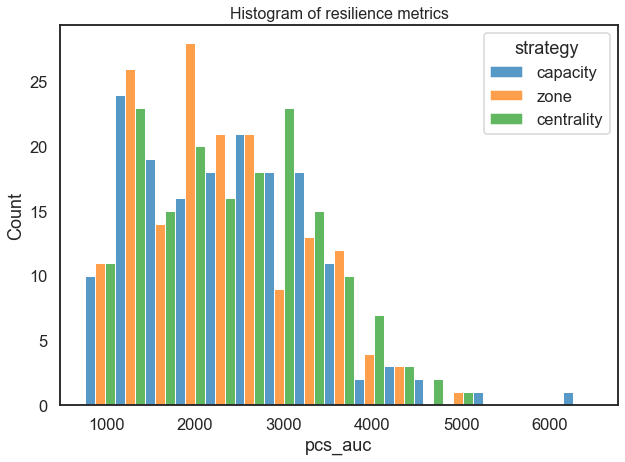

In [106]:
import seaborn as sns
import matplotlib.pyplot as plt


sns.set_context('talk')
fig = plt.figure(figsize = (10,7))
ax = sns.histplot(x= 'pcs_auc', hue = 'strategy', stat="count", multiple="dodge",  data = ml_df, palette=("tab10"))

# ax = sns.kdeplot(data=ml_df, x="pcs_auc", hue="strategy", cumulative=True, common_norm=False, common_grid=True,)

ax.set_title('Histogram of resilience metrics', size = 16)

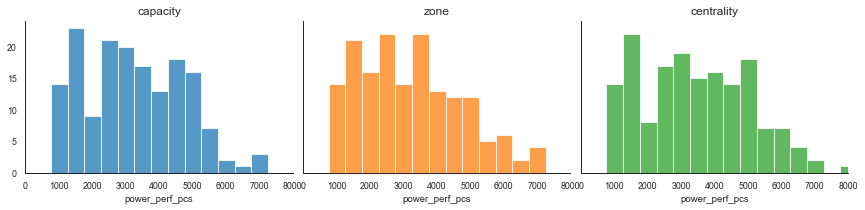

In [107]:

sns.set_theme(style="white")
sns.set_context('paper')
g = sns.FacetGrid(ml_df, hue = 'strategy', col='strategy', col_wrap=3, palette="tab10", height=3, aspect= 1.33 )
#g = (g.map(sns.kdeplot, "power_perf_pcs"))
(g.map(sns.histplot, "power_perf_pcs", stat = 'count', binwidth = 500))
g.set_titles(col_template="{col_name}", fontweight='regular', size=12)
g.set(xlim=(0, 8000))

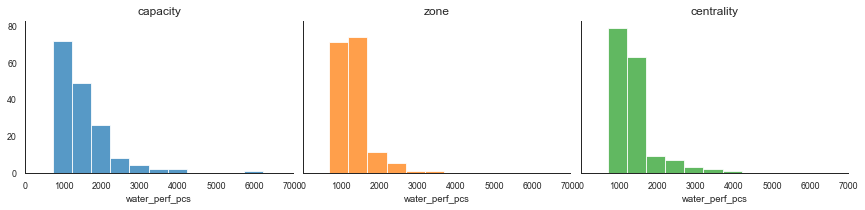

In [108]:

sns.set_theme(style="white")
sns.set_context('paper')
g = sns.FacetGrid(ml_df, hue = 'strategy', col='strategy', col_wrap=3, palette="tab10", height=3, aspect= 1.33 )
#g = (g.map(sns.kdeplot, "power_perf_pcs"))
(g.map(sns.histplot, "water_perf_pcs", stat = 'count', binwidth = 500))
g.set_titles(col_template="{col_name}", fontweight='regular', size=12)
g.set(xlim=(0, 7000))

In [109]:
infra = "power"
y = f"{infra}_perf_pcs"
ml_df_wide = ml_df[['scenario', 'strategy', y]].pivot(index='scenario', columns='strategy', values=y)
ml_df_wide = ml_df_wide.dropna()
ml_df_wide.head()


strategy,capacity,centrality,zone
scenario,,,
flood0,4158.024,3282.024,3718.895
flood1,5013.948,5024.848,4301.397
flood10,4249.991,3949.856,3916.755
flood100,1621.669,1621.669,1412.405
flood101,2664.172,2680.172,2664.172


In [110]:
unique_full_scenarios = ml_df_wide.index.tolist()

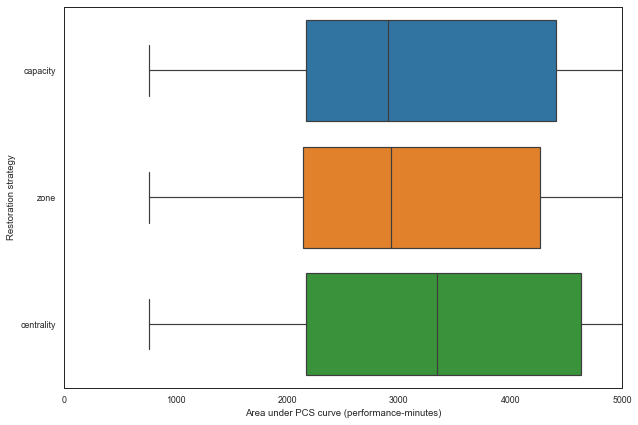

In [111]:
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize = (10,7))
ax = sns.boxplot(y='strategy', x=y, data=ml_df, orient="h", palette = 'tab10')
ax.set_xlabel(f"Area under PCS curve (performance-minutes)")
ax.set_ylabel(f"Restoration strategy")
#ax.set_title(f"Comparison of effectiveness of {infra} restoration strategies")
ax.set_xlim((0, 5000))
plt.show()

In [112]:
#!pip install pingouin
import pingouin as pg
res = pg.rm_anova(dv=y, within='strategy', subject='scenario', data=ml_df, detailed=True)
res

,Source,SS,DF,MS,F,p-unc,np2,eps
0,strategy,4.746619e+06,2,2.373310e+06,9.171582,0.000133,0.05327,0.971697
1,Error,8.435829e+07,326,2.587677e+05,NaN,NaN,NaN,NaN


In [113]:
# install pingouin as !pip install pingouin
# make sure you have installed the pingouin package (pip install pingouin)
ml_df_full = ml_df[ml_df.scenario.isin(unique_full_scenarios)]
post_hocs = pg.pairwise_ttests(dv=y, within='strategy', subject='scenario', padjust='fdr_bh', data=ml_df_full)
post_hocs[['Contrast', 'A', 'B', 'T', 'p-corr']]

,Contrast,A,B,T,p-corr
0,strategy,capacity,centrality,-3.815152,0.000290
1,strategy,capacity,zone,0.184384,0.853943
2,strategy,centrality,zone,3.958782,0.000290


In [114]:
import pingouin as pg
pg.sphericity(data=ml_df, dv=y, subject='scenario', within='strategy')[-1]

0.09258700303649628

In [115]:
pg.normality(data=ml_df, dv=y, group='strategy')

,W,pval,normal
capacity,0.965107,0.000381,False
zone,0.962190,0.000203,False
centrality,0.971078,0.001649,False


In [116]:
ml_df_wide.describe()

strategy,capacity,centrality,zone
count,163.000000,163.000000,163.000000
mean,3241.403840,3448.298485,3230.003411
std,1477.545347,1611.257980,1536.312057
min,764.000000,764.000000,764.000000
25%,2178.254500,2183.966000,2144.805000
50%,2910.253000,3343.913000,2931.595000
75%,4409.611000,4641.736000,4266.107000
max,7105.784000,7797.201000,7007.435000


In [117]:
ml_df_wide.describe().iloc[1,0] - ml_df_wide.describe().iloc[1,1]

-206.89464417177942

In [118]:
ml_df_wide.describe().iloc[1,0] - ml_df_wide.describe().iloc[1,2]

11.40042944785182

In [119]:
ml_df_wide.describe().iloc[1,1] - ml_df_wide.describe().iloc[1,2]

218.29507361963124

In [14]:
import numpy as np
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from sklearn.linear_model import LinearRegression

In [121]:
ml_df.columns

Index(['scenario', 'strategy', 'water_perf_ecs', 'water_perf_pcs',
       'power_perf_ecs', 'power_perf_pcs', 'all_compons', 'power4', 'power3',
       'power5', 'power2', 'power1', 'power6', 'power0', 'power7', 'water1',
       'water4', 'water0', 'water5', 'water2', 'water3', 'water6', 'transpo7',
       'transpo2', 'transpo5', 'transpo1', 'transpo3', 'transpo4', 'transpo0',
       'transpo6', 'ecs_auc', 'pcs_auc'],
      dtype='object')

In [11]:
dep_var = 'pcs_auc'

features = ml_df[['strategy', 'power4', 'power3',
       'power5', 'power2', 'power1', 'power6', 'power0', 'power7', 'water1',
       'water4', 'water0', 'water5', 'water2', 'water3', 'water6', 'transpo7',
       'transpo2', 'transpo5', 'transpo1', 'transpo3', 'transpo4', 'transpo0',
       'transpo6', dep_var]]

In [12]:
features = features.replace('nan',np.NaN)
features = features.dropna()

labels = np.array(features[dep_var])
del features[dep_var]
features = pd.get_dummies(features)

feature_list = list(features.columns)
features = np.array(features)

# Decision Tree Model

In [15]:
clf = ExtraTreesRegressor(n_estimators=500)
clf = clf.fit(features, labels)

print(feature_list)
print(clf.feature_importances_)

pd.DataFrame(data = {'features': feature_list,
                     'feature importance': clf.feature_importances_})

['power4', 'power3', 'power5', 'power2', 'power1', 'power6', 'power0', 'power7', 'water1', 'water4', 'water0', 'water5', 'water2', 'water3', 'water6', 'transpo7', 'transpo2', 'transpo5', 'transpo1', 'transpo3', 'transpo4', 'transpo0', 'transpo6', 'strategy_capacity', 'strategy_centrality', 'strategy_zone']
[0.019 0.016 0.02  0.    0.    0.054 0.019 0.    0.076 0.    0.06  0.193 0.211 0.    0.038 0.038 0.014 0.105 0.    0.022 0.02  0.011 0.008 0.026 0.021 0.027]


,features,feature importance
0,power4,0.018554
1,power3,0.016434
2,power5,0.019906
3,power2,0.000000
4,power1,0.000000
5,power6,0.054488
6,power0,0.018695
7,power7,0.000000
8,water1,0.076220
9,water4,0.000000


In [17]:
from sklearn.model_selection import train_test_split
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (369, 26)
Training Labels Shape: (369,)
Testing Features Shape: (123, 26)
Testing Labels Shape: (123,)


In [18]:
model = SelectFromModel(clf, prefit=True, threshold = '0.5*median')
features_new = model.transform(features)
features_new.shape

(492, 19)

In [19]:
model = SelectFromModel(clf, prefit=True, threshold = '0.5*median')
features_new = model.transform(features)
features_new.shape

(492, 19)

In [20]:
feature_list_new = []

for i, feature in enumerate(feature_list):
    if model.get_support()[i]:
        feature_list_new.append(feature)

feature_list_new

['power4',
 'power3',
 'power5',
 'power6',
 'power0',
 'water1',
 'water0',
 'water5',
 'water2',
 'water6',
 'transpo7',
 'transpo2',
 'transpo5',
 'transpo3',
 'transpo4',
 'transpo0',
 'strategy_capacity',
 'strategy_centrality',
 'strategy_zone']

In [21]:
train_features, test_features, train_labels, test_labels = train_test_split(features_new, labels, test_size = 0.25, random_state = 43)
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (369, 19)
Training Labels Shape: (369,)
Testing Features Shape: (123, 19)
Testing Labels Shape: (123,)


In [22]:
parameters = {'max_depth':range(2,10), 'min_samples_leaf': range(3,10)}
clf = GridSearchCV(tree.DecisionTreeRegressor(), parameters, n_jobs=5, scoring = 'accuracy')
clf.fit(X=features, y=labels)
tree_model = clf.best_estimator_
print (clf.best_score_, clf.best_params_) 

nan {'max_depth': 2, 'min_samples_leaf': 3}


In [23]:
clf = tree.DecisionTreeRegressor(max_depth = 5, random_state = 0, min_samples_leaf=4)
# Train the model on training data
clf.fit(features, labels)

DecisionTreeRegressor(max_depth=5, min_samples_leaf=4, random_state=0)

In [24]:
y_pred=clf.predict(features)   

def measure_performance(y_test, y_pred, X_train):
    from sklearn.metrics import mean_squared_error, r2_score 

    rmse = np.sqrt(mean_squared_error(y_test,y_pred))
    r2 = r2_score(y_test,y_pred)

    # Scikit-learn doesn't have adjusted r-square, hence custom code
    n = y_pred.shape[0]
    k = X_train.shape[1]
    adj_r_sq = 1 - (1 - r2)*(n-1)/(n-1-k)

    print(rmse, r2, adj_r_sq)
    
        
measure_performance(labels,y_pred, features)

380.6623826249612 0.7851810026090782 0.7731696178087256


# Random Forest Model

In [25]:
for i in [1, 10, 20, 50, 100, 500, 1000]:
    regressor = RandomForestRegressor(n_estimators = i, random_state = 1)
    regressor.fit(features, labels)
    y_pred = regressor.predict(features)
    print("n_estimators: ", i, "- Accuracy: ", regressor.score(features, labels))

n_estimators:  1 - Accuracy:  0.8799882377167109
n_estimators:  10 - Accuracy:  0.9597622374389908
n_estimators:  20 - Accuracy:  0.9714822415384727
n_estimators:  50 - Accuracy:  0.973145643119871
n_estimators:  100 - Accuracy:  0.9736581864372025
n_estimators:  500 - Accuracy:  0.9742127416099476
n_estimators:  1000 - Accuracy:  0.9740579296564991


In [26]:
# Evaluating the Algorithm
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(labels, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(labels, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(labels, y_pred)))

Mean Absolute Error: 86.22654951524369
Mean Squared Error: 17498.94517531065
Root Mean Squared Error: 132.28357863057172


In [27]:
measure_performance(labels,y_pred, features)

132.28357863057172 0.9740579296564991 0.9726074052932066


# Linear Regression

In [31]:
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(train_features, train_labels)  # perform linear regression
y_pred = linear_regressor.predict(train_features)  # make predictions

In [32]:
print(feature_list_new)
print(linear_regressor.coef_)

['power4', 'power3', 'power5', 'power6', 'power0', 'water1', 'water0', 'water5', 'water2', 'water6', 'transpo7', 'transpo2', 'transpo5', 'transpo3', 'transpo4', 'transpo0', 'strategy_capacity', 'strategy_centrality', 'strategy_zone']
[  6.048 -81.964  14.059  79.889  -4.642 107.442 133.259  58.252 169.799  76.119 200.912  89.357 197.199  66.382 145.298 -57.17  -97.964  89.201   8.763]


In [33]:
linear_regressor.score(train_features, train_labels, sample_weight=None)

0.7826891256426758